<a href="https://colab.research.google.com/github/Ryan-RE-Wang/BCI_project/blob/main/RF_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import seed
from collections import Counter
from datetime import datetime
import time
import os, sys
import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, cohen_kappa_score, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 3.9 MB/s 


In [4]:
sys.path.append('/content/drive/Shareddrives/BCI/sleep_study/sleep_study')
import sleep_study as ss

# Useful Functions

In [5]:
def get_metrics(y, y_hat, verbose=True):
    cf = confusion_matrix(y, y_hat)
    ncf = 100*confusion_matrix(y, y_hat, normalize='true') # percentage
    precision,recall,mf,support = precision_recall_fscore_support(y,y_hat,average='macro')
    kp = cohen_kappa_score(y, y_hat)
    acc = 100*accuracy_score(y, y_hat) # percentage
    
    if verbose:
        print('\nConfusion Matrix')
        print(cf)
        print('\nNormalized Confusion Matrix')
        print(np.round(ncf))
        print('Accuracy: ', acc)
        print('Precision: ',precision)
        print('Recall: ',recall)
        print('Macro-F1 Score: ',mf)
        print('Kohen Kappa: ',kp)
        
    return {'confusion matrix': cf,
            'normalized confusion matrix': ncf,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'Macro-F1 Score': mf,
            'Kohen Kappa': kp}

In [6]:
def print_all_metrics(res, keys):
    ncf_name = 'normalized confusion matrix'
    
    for i, k in enumerate(keys):
        all_metrics = res[k]
        num_trials = len(all_metrics)
                
        means = pd.DataFrame(data = np.round(np.mean([all_metrics[rr][ncf_name] for rr in range(num_trials)], axis=0), 1), dtype='str')
        stds = pd.DataFrame(data = np.round(np.std([all_metrics[rr][ncf_name] for rr in range(num_trials)], axis=0), 1), dtype='str')
        tbl = (means + " " + u"\u00B1" + " " + stds).to_numpy()
        print(ncf_name)
        print(tbl) # I want normalized CF to print nicely with mean \pm standard deviation.

        for j in ['accuracy', 'precision', 'recall', 'Macro-F1 Score', 'Kohen Kappa']:
            m = str(np.round(np.mean([all_metrics[rr][j] for rr in range(num_trials)]), 3))
            s = str(np.round(np.std([all_metrics[rr][j] for rr in range(num_trials)]), 3))
            print(j, ":", m + " " + u"\u00B1" + " " + s)
        print( )

In [7]:
def get_npz_file_names(path):
    files = []
    with os.scandir(path) as it:
        for entry in it:
            if (entry.name.endswith('.npz') or entry.name.endswith('.NPZ')) and entry.is_file():
                files.append(path+entry.name)
    return files

In [8]:
def load_features(fn, verbose=False):   
    X = np.load(fn, allow_pickle=True)
    data, features, labels = X['data'], X["features"], X["labels"]
    if verbose:
        print(fn)
        print(features.shape, labels.shape)
        
    return data, features, labels

In [9]:
def train_test_classifier(idxs, data, clf, verbose=True):
    
    train_idx, test_idx = idxs
    X, y = data
    
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]
    
    if verbose:
        print('train set class distribution', sorted(Counter(y_train).items()))
        print('test set class distribution', sorted(Counter(y_test).items()))

    t = time.time()
    clf.fit(X_train, y_train)

    if verbose:
        print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

    y_hat = clf.predict(X_test)

    metrics = get_metrics(y_test, y_hat, verbose=False)
    
    y_pred = clf.predict_proba(X_test)

    plot_roc(np.eye(5)[y_test], y_pred)

    if verbose:
        print(metrics)
        print( )

    return metrics, y_hat

In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score


def plot_roc(y_test, preds):
    fig = plt.figure(figsize=(8,6))
    
    for i in range(5):
        fpr, tpr, _ = roc_curve(y_test[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        # plot the roc curve for the model
        plt.plot(fpr, tpr, linestyle='solid', label='Label:{} AUC={:.3f}'.format(i, roc_auc))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
#     filename = title + '.svg'
#     plt.savefig(filename)
    plt.show()

# Random Forest

In [ ]:
all_eeg_wave = []
all_eog_wave = []
all_eeg_features = []
all_eog_features = []
all_labels = []

feature_files = get_npz_file_names('/content/drive/Shareddrives/BCI/BCI_Data/Sleep_Data/')

for fn in feature_files:
    data, features, labels = load_features(fn)

    # if (features.shape[1:] != (9, 12)):
    #     continue
    all_eeg_wave.extend(data[:, :7])
    all_eog_wave.extend(data[:, 7:])
    all_eeg_features.extend(features[:, :7])
    all_eog_features.extend(features[:, 7:])

    all_labels.extend(labels)

all_eeg_wave = np.array(all_eeg_wave)
all_eog_wave = np.array(all_eog_wave)
all_eeg_features = np.array(all_eeg_features)
all_eog_features = np.array(all_eog_features)
all_labels = np.array(all_labels)

In [13]:
all_labels.shape

(622,)

train set class distribution [(0, 333), (1, 62), (2, 43), (3, 14), (4, 14)]
test set class distribution [(0, 111), (1, 21), (2, 15), (3, 5), (4, 4)]
training took 0.08 minutes.
{'confusion matrix': array([[111,   0,   0,   0,   0],
       [ 21,   0,   0,   0,   0],
       [ 15,   0,   0,   0,   0],
       [  5,   0,   0,   0,   0],
       [  4,   0,   0,   0,   0]]), 'normalized confusion matrix': array([[100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.]]), 'accuracy': 71.15384615384616, 'precision': 0.1423076923076923, 'recall': 0.2, 'Macro-F1 Score': 0.16629213483146066, 'Kohen Kappa': 0.0}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


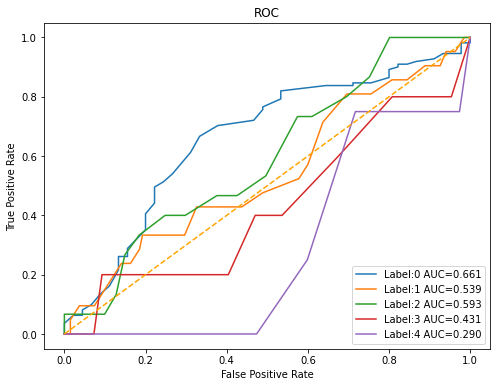

In [ ]:
np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(all_eeg_wave, all_labels, stratify=all_labels)
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test)

plot_roc(np.eye(5)[y_test], y_pred)

train set class distribution [(0, 333), (1, 62), (2, 43), (3, 14), (4, 14)]
test set class distribution [(0, 111), (1, 21), (2, 15), (3, 5), (4, 4)]
training took 0.07 minutes.
{'confusion matrix': array([[111,   0,   0,   0,   0],
       [ 21,   0,   0,   0,   0],
       [ 15,   0,   0,   0,   0],
       [  5,   0,   0,   0,   0],
       [  4,   0,   0,   0,   0]]), 'normalized confusion matrix': array([[100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.]]), 'accuracy': 71.15384615384616, 'precision': 0.1423076923076923, 'recall': 0.2, 'Macro-F1 Score': 0.16629213483146066, 'Kohen Kappa': 0.0}


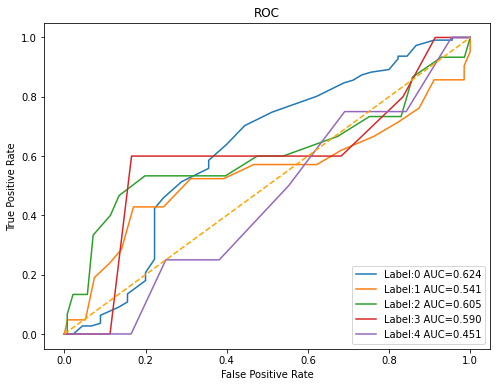

In [ ]:
from sklearn.decomposition import FastICA
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

all_eeg_wave_processed = []
for i in all_eeg_wave:
    transformer = FastICA(whiten='unit-variance', random_state=2022)

    all_eeg_wave_processed.append(np.abs(np.fft.rfft(transformer.fit_transform(i.T))))

all_eeg_wave_processed = np.array(all_eeg_wave_processed)

X_train_ica, X_test_ica, y_train, y_test = train_test_split(all_eeg_wave_processed, all_labels, stratify=all_labels)

X_train_ica = np.reshape(X_train_ica, (len(X_train_ica), -1))
X_test_ica = np.reshape(X_test_ica, (len(X_test_ica), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train_ica, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test_ica)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test_ica)

plot_roc(np.eye(5)[y_test], y_pred)

train set class distribution [(0, 28687), (1, 10159), (2, 10146), (3, 4330), (4, 1751)]
test set class distribution [(0, 9562), (1, 3386), (2, 3382), (3, 1444), (4, 584)]
training took 2.22 minutes.
{'confusion matrix': array([[9304,  104,  124,   27,    3],
       [1861, 1419,   97,    8,    1],
       [2360,  231,  779,   10,    2],
       [1106,   73,   24,  235,    6],
       [ 490,   41,   42,    5,    6]]), 'normalized confusion matrix': array([[9.73018197e+01, 1.08763857e+00, 1.29679983e+00, 2.82367706e-01,
        3.13741895e-02],
       [5.49616066e+01, 4.19078559e+01, 2.86473715e+00, 2.36266982e-01,
        2.95333727e-02],
       [6.97811946e+01, 6.83027794e+00, 2.30337079e+01, 2.95683028e-01,
        5.91366056e-02],
       [7.65927978e+01, 5.05540166e+00, 1.66204986e+00, 1.62742382e+01,
        4.15512465e-01],
       [8.39041096e+01, 7.02054795e+00, 7.19178082e+00, 8.56164384e-01,
        1.02739726e+00]]), 'accuracy': 63.96666303518902, 'precision': 0.6527206325203734, '

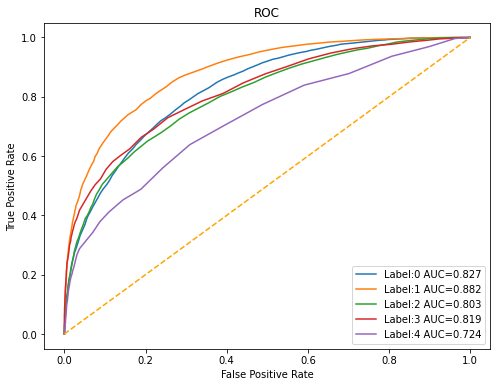

In [ ]:
np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(all_eeg_features, all_labels, stratify=all_labels)
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test)

plot_roc(np.eye(5)[y_test], y_pred)

# RNN

In [ ]:
all_eeg_features = []
all_eog_features = []
all_labels = []

feature_files = get_npz_file_names('/content/drive/Shareddrives/BCI/BCI_Data/Sleep_Data/')

for fn in feature_files:
    features, labels = load_features(fn)

    # if (features.shape[1:] != (9, 12)):
    #     continue

    all_eeg_features.extend(features[:, :7])
    all_eog_features.extend(features[:, 7:])

    all_labels.extend(labels)

all_eeg_features = np.array(all_eeg_features)
all_eog_features = np.array(all_eog_features)
all_labels = np.array(all_labels)

In [ ]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.3839629794242987,
 1: 1.0842524916943521,
 2: 1.085615020697812,
 3: 2.5435053688950466,
 4: 6.289593147751606}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_eeg_features, all_labels, stratify=all_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)

y_train = np.eye(5)[y_train]
y_val = np.eye(5)[y_val]
y_test = np.eye(5)[y_test]

X_train = np.reshape(X_train, (len(X_train), 7, 12, 1))
X_val = np.reshape(X_val, (len(X_val), 7, 12, 1))
X_test = np.reshape(X_test, (len(X_test), 7, 12, 1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwise  (None, 7, 12, 1)         22        
 Conv2D)                                                         
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 7, 12, 1)         8         
 seConv2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 7, 12, 1)         4         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 12, 1)          0         
                                                                 
 average_pooling2d (AverageP  (None, 7, 4, 1)          0         
 ooling2D)                                              

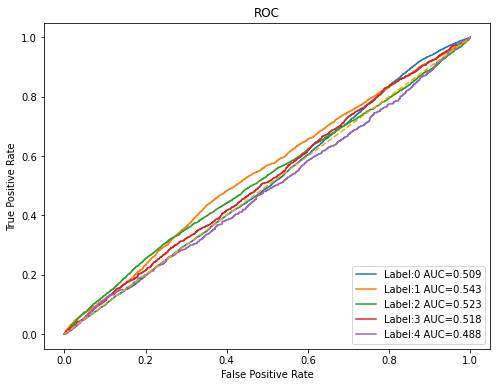

In [ ]:
from keras import backend as K

def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   

model = keras.models.Sequential()
model.add(keras.layers.Input((7, 12, 1)))

model.add(keras.layers.DepthwiseConv2D(kernel_size=(7, 3), padding="same"))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.ReLU())

model.add(keras.layers.DepthwiseConv2D(kernel_size=(7, 1), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation(square))
# model.add(keras.layers.ReLU())

# model.add(keras.layers.Conv1D(filters=16, kernel_size=3, padding="same"))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.ReLU())

model.add(keras.layers.AveragePooling2D(pool_size=(1, 3)))
model.add(keras.layers.Activation(log))

model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='AUC')

model.summary()

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(X_train, y_train, epochs=100, batch_size=32, class_weight=class_weights, validation_data=(X_val, y_val), callbacks=model_checkpoint_callback)

y_pred = model.predict(X_test)

plot_roc(y_test, y_pred)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Input((7, 12)))

model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())

model.add(keras.layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())

model.add(keras.layers.Conv1D(filters=16, kernel_size=3, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())

# model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Flatten())

# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='AUC')

model.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

X_train_ps = np.abs(np.fft.rfft(X_train, axis=1))
X_val_ps = np.abs(np.fft.rfft(X_val, axis=1))
history = model.fit(np.abs(np.fft.rfft(X_train, axis=1)), y_train, epochs=100, batch_size=16, class_weight=class_weights, validation_data=(np.abs(np.fft.rfft(X_val, axis=1)), y_val), callbacks=callback)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 7, 64)             2368      
                                                                 
 batch_normalization_40 (Bat  (None, 7, 64)            256       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 7, 64)             0         
                                                                 
 conv1d_13 (Conv1D)          (None, 7, 32)             6176      
                                                                 
 batch_normalization_41 (Bat  (None, 7, 32)            128       
 chNormalization)                                                
                                                                 
 re_lu_13 (ReLU)             (None, 7, 32)            

ValueError: ignored

In [ ]:
from sklearn.decomposition import PCA

X_train_ps = np.abs(np.fft.rfft(X_train, axis=1))
X_val_ps = np.abs(np.fft.rfft(X_val, axis=1))

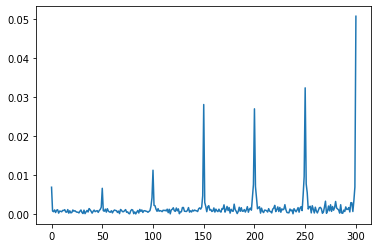

In [ ]:
plt.plot(X_train_ps[0, :, 0])

In [ ]:
pca = PCA(n_components=10)
a = pca.fit_transform(X_train_ps[:, :, 0])

In [ ]:
a.shape

(1219, 10)